# Validation with DJA catalog

This notebook compares the results from SourceXtractor++ to the catalogs from the [DAWN JWST Archive (DJA)](https://dawn-cph.github.io/dja/). It also performs some morphological sanity checks to validate the measurements made.

In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
import boto3
s3 = boto3.client('s3')
import dja_sepp
from dja_sepp.utils import color_dict, channel_color_dict, channel_dict

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

In [34]:
home = "/home/aurelien/DAWN/DJA-SEpp/"
field = 'ceers-full-grizli-v7.2'
fit = 'B+D'

Download SE++ catalog from S3 bucket

In [35]:
# Find catalog
cat_file = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                                   path=f'{field}/sepp/{fit}', 
                                   regex=".+tile-full+_sepp_cat\.fits")[0]
cat_file

IndexError: list index out of range

In [ ]:
cat_folder = f"{home}/fields/{field}/sepp/{fit}"
os.makedirs(cat_folder, exist_ok=True)
s3.download_file('aurelien-sepp', f"{field}/sepp/{fit}/{cat_file}", f"{cat_folder}/{cat_file}")

First, we load the DJA catalog and the SE++ catalog.

In [36]:
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_sepp = Table(hdul[1].data)

We compare the number of sources in each catalog :
* Complete DJA catalog
* Complete SE++ catalog
* Cutout of the DJA catalog with the same footprint as the SE++ catalog

In [37]:
print(f"Sources in DJA catalog  : {len(phot_dja)}")
# print(phot_dja.keys())
print(f"Sources in SE++ catalog : {len(phot_sepp)}")
print(phot_sepp.keys())
# sepp_ra_min, sepp_ra_max = np.min(phot_sepp['world_centroid_alpha']), np.max(phot_sepp['world_centroid_alpha'])
# sepp_de_min, sepp_de_max = np.min(phot_sepp['world_centroid_delta']), np.max(phot_sepp['world_centroid_delta'])
# phot_dja_cutout = phot_dja[(phot_dja['ra']>sepp_ra_min)&(phot_dja['ra']<sepp_ra_max)&(phot_dja['dec']>sepp_de_min)&(phot_dja['dec']<sepp_de_max)]
# print(f"Sources in DJA cutout   : {len(phot_dja_cutout)}")

Sources in DJA catalog  : 76637
Sources in SE++ catalog : 340627
['pixel_centroid_x', 'pixel_centroid_y', 'world_centroid_alpha', 'world_centroid_delta', 'source_id', 'detection_id', 'group_id', 'group_stamp_top', 'group_stamp_left', 'group_stamp_width', 'group_stamp_height', 'source_flags', 'n_detected_pixels', 'n_core_pixel', 'APER_flux', 'APER_flux_err', 'APER_mag', 'APER_mag_err', 'APER_flags', 'auto_flux', 'auto_flux_err', 'auto_mag', 'auto_mag_err', 'auto_flags', 'flux_radius', 'snrratio', 'ellipse_a', 'ellipse_b', 'ellipse_theta', 'ellipse_cxx', 'ellipse_cyy', 'ellipse_cxy', 'area', 'elongation', 'ellipticity', 'fmf_reduced_chi_2', 'fmf_iterations', 'fmf_stop_reason', 'fmf_duration', 'fmf_flags', 'fmf_chi2_per_meta', 'fmf_iterations_per_meta', 'fmf_meta_iterations', 'X_MODEL', 'X_MODEL_err', 'Y_MODEL', 'Y_MODEL_err', 'RA_MODEL', 'RA_MODEL_err', 'DEC_MODEL', 'DEC_MODEL_err', 'DISK_RADIUS_pix', 'DISK_RADIUS_pix_err', 'BULGE_RADIUS_pix', 'BULGE_RADIUS_pix_err', 'DISK_RADIUS_deg', '

We do a scatter plot of all the sources to visually see the footprint of the SE++ catalog.

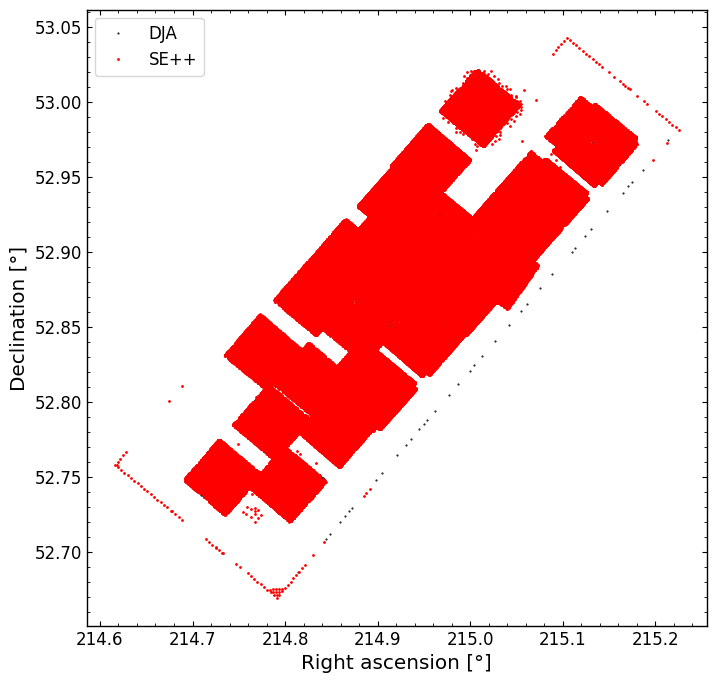

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_sepp['world_centroid_alpha'], phot_sepp['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label='SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.88, 214.95)
# ax.set_ylim(52.83, 52.88)
ax.legend()
plt.show()

We cross-match the two catalogs to compare them later...

In [39]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sepp = SkyCoord(phot_sepp['world_centroid_alpha']*u.degree, phot_sepp['world_centroid_delta']*u.degree)
idx, d2d, _ = coord_sepp.match_to_catalog_sky(coord_dja)

... and we remove the matches further than `max_sep`.

In [40]:
max_sep = 0.3*u.arcsec
phot_dja_match = phot_dja[idx][d2d<max_sep]
phot_sepp_match = phot_sepp[d2d<max_sep]
print(f"Matched sources : {len(phot_sepp_match)}")

# phot_dja_unmatch = [source for source in phot_dja_cutout if (source['id'] not in phot_dja_match['id'])]
# print(f"Un-matched sources in DJA : {len(phot_dja_unmatch)}")

Matched sources : 66553


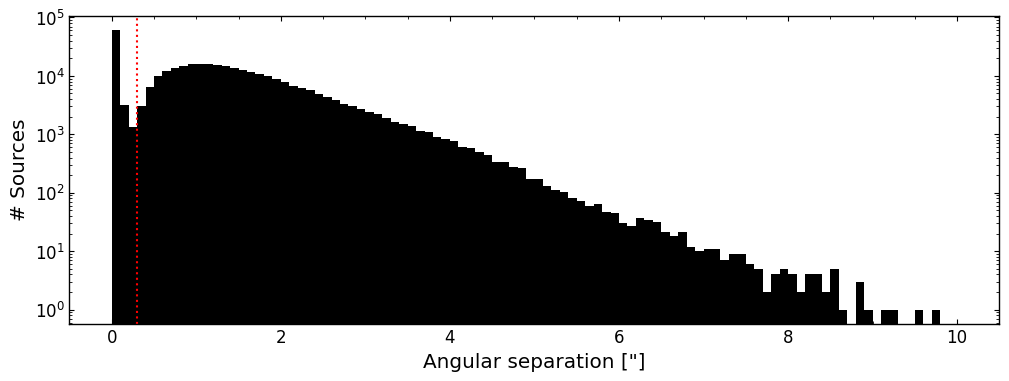

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(d2d.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='k')
ax.axvline(max_sep.value, color='r', ls=':')
ax.set_yscale('log')
ax.set_xlabel('Angular separation ["]')
ax.set_ylabel('# Sources')
plt.show()

## Magnitude comparison

Now that the SE++ sources are matched to the DJA catalog, it's possible to compare the values obtained with SE++ to the one from the DJA (obtained with SExtractor). 

First, we compare the magnitudes. The dictionaries at the start are there to make a nice plot with the colored name of each (JWST) filter.

/tmp/ipykernel_8827/2286565278.py:7: RuntimeWarning: invalid value encountered in log10
  mag_dja = ZP - 2.5*np.log10(phot_dja[f'{filter}_tot_1']*1000)


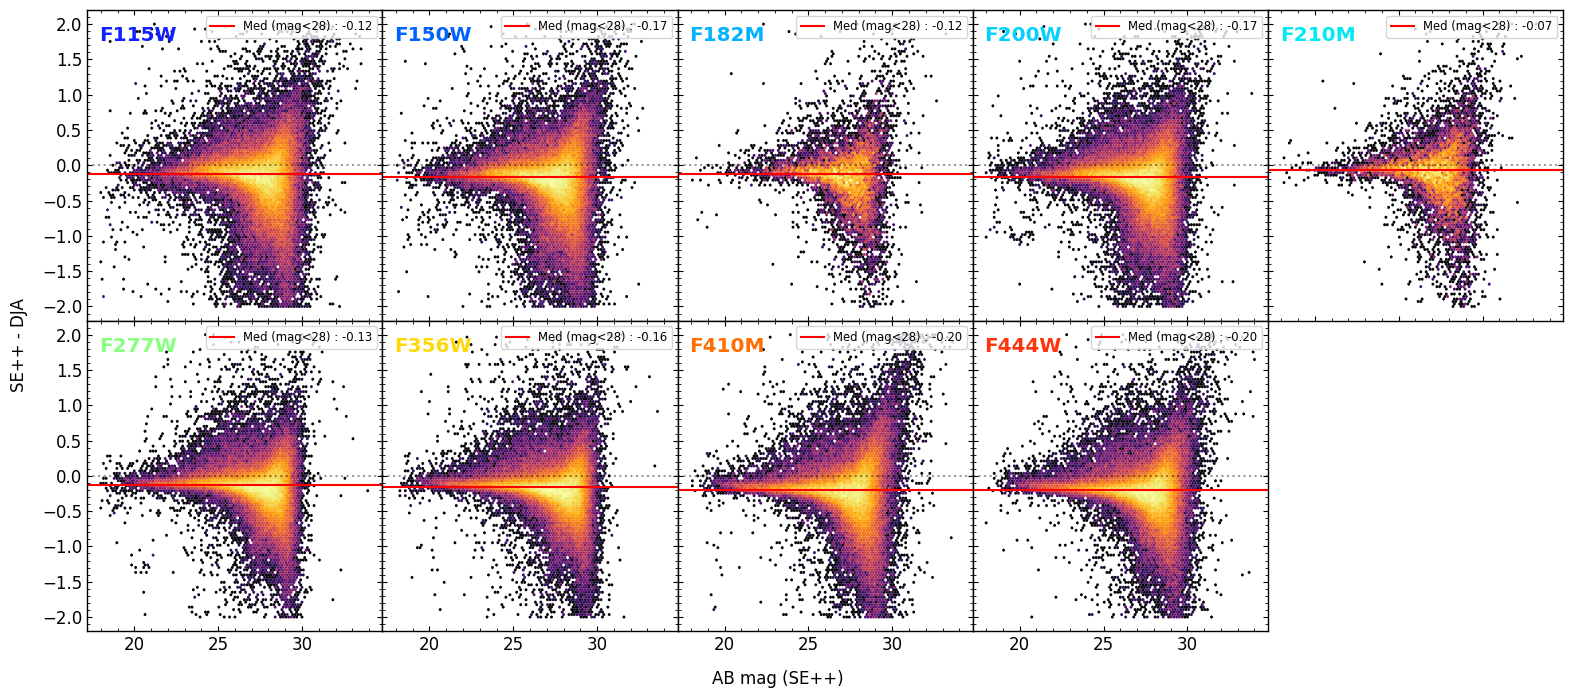

In [42]:
filter_list = dja_sepp.utils.get_filter_list(phot_sepp.keys())

def plot_mag(ax, filter, phot_sepp, phot_dja):
    ax.axhline(0, color='k', alpha=0.4, ls=':')
    ZP = (1*u.nJy).to(u.ABmag).value
    mag_sepp = ZP - 2.5*np.log10(phot_sepp[f'FLUX_MODEL_{filter.upper()}']*10)
    mag_dja = ZP - 2.5*np.log10(phot_dja[f'{filter}_tot_1']*1000)
    delta_28 = np.nanmedian((mag_sepp-mag_dja)[mag_sepp<28])

    ax.hexbin(mag_sepp, mag_sepp - mag_dja, mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(18,34,-2,2), lw=0.01)
    ax.axhline(delta_28, color='r', label=f"Med (mag<28) : {delta_28:.2f}")
    ax.text(0.04, 0.9, filter.upper(), transform=ax.transAxes, fontsize='x-large', fontweight='bold', color=color_dict[filter.upper()])
    ax.legend(loc='upper right', fontsize='small')

fig, axs = dja_sepp.utils.plot_group_filter(filter_list, plot_mag, phot_sepp=phot_sepp_match, phot_dja=phot_dja_match)
fig.supylabel("SE++ - DJA")
fig.supxlabel("AB mag (SE++)")
fig.tight_layout(rect=(0.02, -0.01, 1.0, 1.0))
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_DJAvSEpp.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_DJAvSEpp.png", bbox_inches='tight', dpi=200)
plt.show()

## Morphological distributions

As a sanity check, we can also look at some morphological distributions to look for any anomalies. Here we look at the radius, the aspect ratio and the Sersic index versus the magnitude (in the F277W band) for each source.

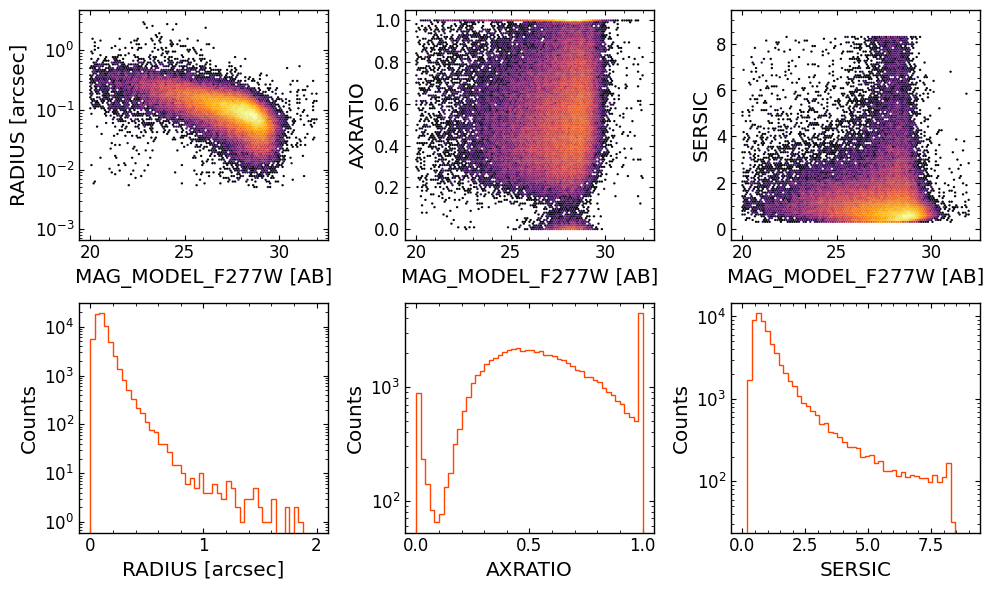

In [31]:
# sersic_rg4

cat = phot_sepp_match
# cat = phot_sepp
# cat = phot_sepp[phot_sepp['RADIUS']*3600>0]
cat = cat[(cat['RADIUS']*3600>5e-3)&(cat['SERSIC']<8.3)]

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,9), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(cat['RADIUS']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(cat['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(cat['SERSIC'], bins=50, range=(0,9), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

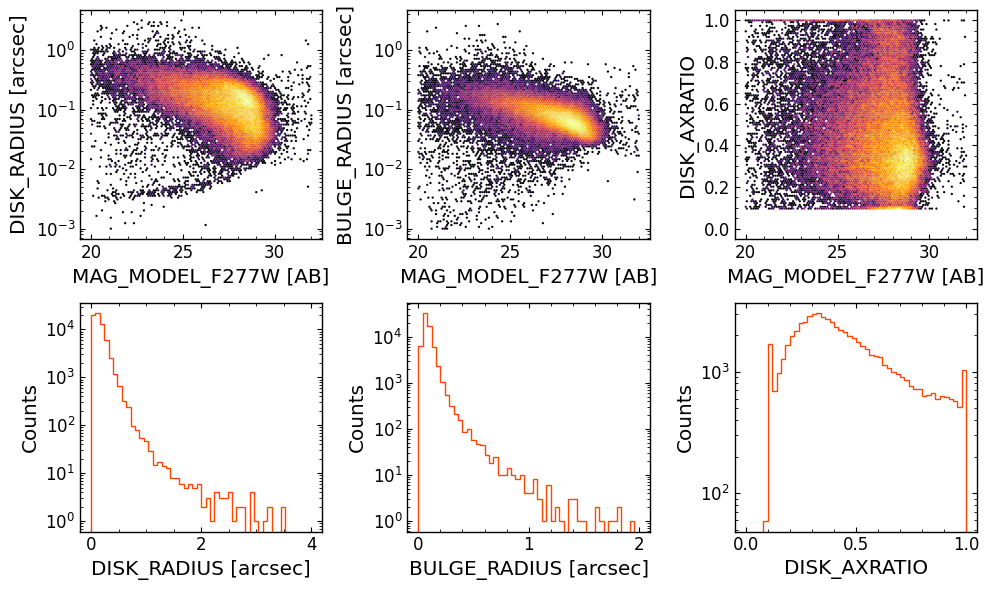

In [43]:
# B+D

cat = phot_sepp_match
# cat = phot_sepp

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[0,1].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,2].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("DISK_AXRATIO")

axs[1,0].hist(cat['DISK_RADIUS_deg']*3600, bins=50, range=(0,4), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("DISK_RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(cat['BULGE_RADIUS_deg']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("BULGE_RADIUS [arcsec]")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(cat['DISK_AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("DISK_AXRATIO")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-{fit}_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

## Sample looking

Since SourceXtractor++ creates model and residual images, we can look at how it performed for different sources, on all bands. The following functions display the data, model and residual images for the different bands, for different sources.

In [15]:
for id in np.random.randint(0, len(phot_sepp_match), 10):
    dja_sepp.utils.show_source(id, phot_sepp_match, filter_list, fov=5*u.arcsec,
                               data_folder=f"{home}/fields/{field}/image",
                               model_folder=f"{home}/fields/{field}/sepp/{fit}/checkimages",
                               resid_folder=f"{home}/fields/{field}/sepp/{fit}/checkimages", 
                               data_suffix="sci.fits",
                               model_suffix="sci_tile-full_1.fits",
                               resid_suffix="sci_tile-full_1.fits")

IndexError: list index out of range

<Figure size 1900x650 with 0 Axes>